In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [12]:
from keras import backend as K
import tensorflow as tf
with K.tf.device('/gpu:0'):
    config = tf.ConfigProto(device_count = {'CPU' : 1, 'GPU' : 1})
    session = tf.Session(config=config)
    K.set_session(session)

In [13]:
import pandas as pd
import logging
import glob
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 500)
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
traindf, testdf = train_test_split(pd.read_csv('github_issues.csv').sample(n=1000000),
                                   test_size=.10)

train_body_raw = traindf.body.tolist()
train_title_raw = traindf.issue_title.tolist()

#traindf
eng_rec = list()
for i in range(len(traindf)):
    temp_ord = ord(traindf.iloc[i,:].issue_title[0])
    if((temp_ord >= ord('a') and temp_ord <= ord('z'))
       or(temp_ord >= ord('A') and temp_ord <= ord('Z'))or(temp_ord >= ord('0') and temp_ord <= ord('9'))): 
        eng_rec.append(i)
traindf = traindf.iloc[eng_rec]
#testdf
eng_rec = list()
for i in range(len(testdf)):
    temp_ord = ord(testdf.iloc[i,:].issue_title[0])
    if((temp_ord >= ord('a') and temp_ord <= ord('z'))
       or(temp_ord >= ord('A') and temp_ord <= ord('Z'))or(temp_ord >= ord('0') and temp_ord <= ord('9'))): 
        eng_rec.append(i)
testdf = testdf.iloc[eng_rec]

latent_dim = 300
from ktext.preprocess import processor

body_pp = processor(keep_n=8000, padding_maxlen=70)
train_body_vecs = body_pp.fit_transform(train_body_raw)

title_pp = processor(append_indicators=True, keep_n=4500,
                     padding_maxlen=12, padding ='post')

# process the title data
train_title_vecs = title_pp.fit_transform(train_title_raw)

import dill as dpickle
import numpy as np

# Save the preprocessor
with open('body_pp.dpkl', 'wb') as f:
    dpickle.dump(body_pp, f)

with open('title_pp.dpkl', 'wb') as f:
    dpickle.dump(title_pp, f)

# Save the processed data
np.save('train_title_vecs.npy', train_title_vecs)
np.save('train_body_vecs.npy', train_body_vecs)

from seq2seq_utils import load_decoder_inputs, load_encoder_inputs, load_text_processor

encoder_input_data, doc_length = load_encoder_inputs('train_body_vecs.npy')
decoder_input_data, decoder_target_data = load_decoder_inputs('train_title_vecs.npy')
sum_length = decoder_input_data.shape[1]

num_encoder_tokens, body_pp = load_text_processor('body_pp.dpkl')
num_decoder_tokens, title_pp = load_text_processor('title_pp.dpkl')

Shape of encoder input: (900000, 70)
Shape of decoder input: (900000, 11)
Shape of decoder target: (900000, 11)
Size of vocabulary for body_pp.dpkl: 8,002
Size of vocabulary for title_pp.dpkl: 4,502


In [14]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Input, LSTM, GRU, Dense, Embedding, Bidirectional, BatchNormalization, SimpleRNN, RepeatVector, Flatten, TimeDistributed
from keras import optimizers


def define_models(n_input, n_output, n_units):
    # define training encoder
    encoder_inputs = Input(shape=(n_input,), name="Encoder-Input")
    x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
    x = BatchNormalization(name='Encoder-Batchnorm-1')(x)
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(x)
    encoder_states = [state_h, state_c]
    encoder_model = Model(encoder_inputs, encoder_states, name='Encoder-Model')

    # define training decoder
    decoder_inputs = Input(shape=(None,), name="Decoder-Input")
    dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
    dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_bn, initial_state=encoder_states)
    x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_outputs)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax',name='Final-Output-Dense')
    decoder_outputs = decoder_dense(x)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # define inference decoder
    decoder_state_input_h = Input(shape=(None,))
    decoder_state_input_c = Input(shape=(None,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(dec_bn, initial_state=decoder_states_inputs)
    x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_outputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(x)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    # return all models
    return model, encoder_model, decoder_model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      (None, 70)           0                                            
__________________________________________________________________________________________________
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Body-Word-Embedding (Embedding) (None, 70, 300)      2400600     Encoder-Input[0][0]              
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 300)    1350600     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Ba

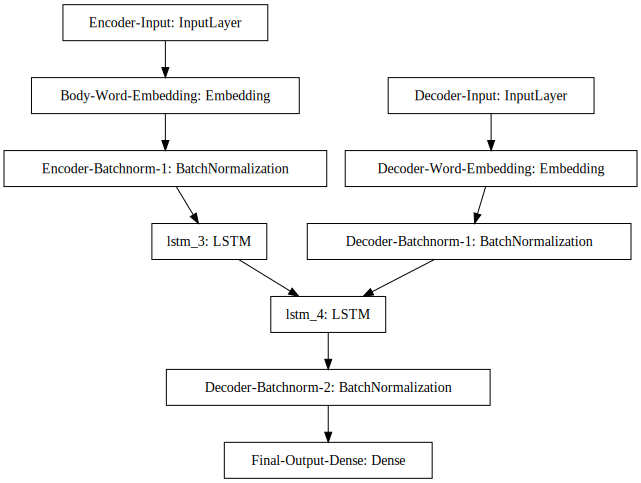

Train on 792000 samples, validate on 108000 samples
Epoch 1/5
792000/792000 [==============================] - 215s 272us/step - loss: 3.0047 - val_loss: 2.5769


/home/shirley/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_4:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/5
792000/792000 [==============================] - 125s 158us/step - loss: 2.4459 - val_loss: 2.4591
Epoch 3/5
792000/792000 [==============================] - 125s 158us/step - loss: 2.3104 - val_loss: 2.4292
Epoch 4/5
792000/792000 [==============================] - 128s 162us/step - loss: 2.2289 - val_loss: 2.4224
Epoch 5/5
792000/792000 [==============================] - 153s 194us/step - loss: 2.1685 - val_loss: 2.4285


In [15]:

from keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'tutorial_seq2seq'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 1200
epochs = 5

model, encoder_model, decoder_model = define_models(doc_length, 11, 300)

model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')
model.summary()

from seq2seq_utils import viz_model_architecture
viz_model_architecture(model)

history = model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.12, callbacks=[csv_logger, model_checkpoint])

#save model
model.save('model_tutorial.h5')

In [18]:
class Seq2Seq_Inference(object):
    def __init__(self,
                 encoder_preprocessor,
                 decoder_preprocessor,):

        self.pp_body = encoder_preprocessor
        self.pp_title = decoder_preprocessor
        self.seq2seq_model, self.encoder_model, self.decoder_model = model, encoder_model, decoder_model
        self.default_max_len_title = self.pp_title.padding_maxlen
        self.nn = None
        self.rec_df = None
    def generate_issue_title(self,
                             raw_input_text,
                             max_len_title=None):
        if max_len_title is None:
            max_len_title = self.default_max_len_title
        raw_tokenized = self.pp_body.transform([raw_input_text])
        body_encoding = self.encoder_model.predict(raw_tokenized)
        original_body_encoding = body_encoding
        state_value = np.array(self.pp_title.token2id['_start_']).reshape(1, 1)
        decoded_sentence = []
        stop_condition = False
        while not stop_condition:
            preds, st_h, st_c = self.decoder_model.predict([state_value] + body_encoding)
            pred_idx = np.argmax(preds[:, :, 2:]) + 2
            pred_word_str = self.pp_title.id2token[pred_idx]

            if pred_word_str == '_end_' or len(decoded_sentence) >= max_len_title:
                stop_condition = True
                break
            decoded_sentence.append(pred_word_str)
            body_encoding = [st_h, st_c]
            state_value = np.array(pred_idx).reshape(1, 1)

        return original_body_encoding, ' '.join(decoded_sentence)

    def print_example(self,
                      i,
                      body_text,
                      title_text,):
        if i:
            print(f'Example # {i}')
        print(f"Issue Body:\n {body_text} \n")
        if title_text:
            print(f"Original Title: {title_text}")
        emb, gen_title = self.generate_issue_title(body_text)
        print(f"\n****** Machine Generated Title (Prediction) ******: {gen_title}\n")



    def demo_model_predictions(self,
                               n,
                               issue_df,
                               threshold=1):
        body_text = issue_df.body.tolist()
        title_text = issue_df.issue_title.tolist()
        url = issue_df.issue_url.tolist()

        demo_list = np.random.randint(low=1, high=len(body_text), size=n)
        for i in demo_list:
            self.print_example(i,
                               body_text=body_text[i],
                               title_text=title_text[i],)



seq2seq_inf = Seq2Seq_Inference(encoder_preprocessor=body_pp,
                                 decoder_preprocessor=title_pp)

seq2seq_inf.demo_model_predictions(n=5, issue_df=testdf)

Example # 48374
Issue Body:
 _i have:_ - x searched existing issues http://github.com/darkstarproject/darkstar/issues/ to see if the issue i am posting has already been addressed or opened by another contributor - x checked the commit log to see if my issue has been resolved since my server was last updated _client version_ type /ver in game : 30170905_05 _server version_ type !revision in game : unknown _source branch_ master/stable : master _additional information_ steps to reproduce/expected behavior : i think this https://github.com/darkstarproject/darkstar/blob/master/scripts/globals/abilities/pets/somnolence.lua is basically missing a: target:delhp dmg ; target:updateenmityfromdamage pet,dmg ; one thing i couldn't figure out though is why it says target takes 0 points of damage when i use it. i'm assuming the returned value is for the message? other than that it won't be doing any damage at all. 

Original Title: somnolence has damage calculation but doesn't subtract it from targ

In [21]:
# Import the ROUGE Package
from rouge import Rouge

rouge = Rouge()

test_title_text = testdf.issue_title.tolist()
test_body_text = testdf.body.tolist()
predict_title_text = [None]*len(test_body_text)
rouge_1_f, rouge_2_f, rouge_l_f = 0, 0, 0

length = len(test_body_text)

# Generate the title for each issue body
for i in range(length):
    exm, predict_title_text[i] = seq2seq_inf.generate_issue_title(raw_input_text=test_body_text[i])
    if i%1000==0:
        print(i)
        
def calculate_rouge():
    rouge_1_f, rouge_2_f, rouge_l_f = 0, 0, 0
    for i in range(length):
        # The rouge package does not accept empty strings 
        if predict_title_text[i]=="":
            predict_title_text[i] = "issue"
            
        scores = rouge.get_scores(predict_title_text[i], test_title_text[i])
        rouge_1_f = rouge_1_f + scores[0]['rouge-1']['f']
        rouge_2_f = rouge_2_f + scores[0]['rouge-2']['f']
        rouge_l_f = rouge_l_f + scores[0]['rouge-l']['f']
        if i%1000==0:
            print("ROUGE-l-f:", rouge_l_f)
    print("ROUGE-1:", rouge_1_f / len(test_body_text))
    print("ROUGE-2:", rouge_2_f / len(test_body_text))
    print("ROUGE-l:", rouge_l_f / len(test_body_text))
    print("Average of ROUGE-1, ROUGE-2 and ROUGE-l: ", (rouge_1_f + rouge_2_f + rouge_l_f) / 3 / len(test_body_text))

calculate_rouge()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
ROUGE-l-f: 0.15205724508016866
ROUGE-l-f: 129.41565725026797
ROUGE-l-f: 247.62439126921305
ROUGE-l-f: 381.18679074955537
ROUGE-l-f: 519.5097222781053
ROUGE-l-f: 651.8398995231631
ROUGE-l-f: 779.4153141548747
ROUGE-l-f: 904.9867820929622
ROUGE-l-f: 1030.2055907869849
ROUGE-l-f: 1158.915786729178
ROUGE-l-f: 1281.3565026101828
ROUGE-l-f: 1419.68698149768
ROUGE-l-f: 1547.1102205676752
ROUGE-l-f: 1681.0588629659687
ROUGE